# Demo 1: Benchmark a language model for performance optimization

Benchmarking a language model is like taking a car for a test drive before buying it—you are measuring performance under realistic conditions to understand its capabilities, limitations, and areas for improvement before committing to deployment.

>**Overview**: We'll evaluate a pre-trained language model on real-world customer queries, analyzing both technical metrics (latency, memory) and business metrics (cost, quality).
> 
> **Goal**: Identify optimization opportunities and make data-driven decisions about potential compression strategies, by collecting key metrics across technical performance and business impact.
> 
> **Scenario**: Imagine you are part of a customer support team who wants to deploy an AI chatbot to handle customer queries, answering questions like:
> <br> ・ _"How do I reset my password?"_
> <br> ・ _"What is your refund policy?"_
> <br> ・ _"Where is my order?"_
> <br> You've selected a small Llama model due to its efficiency, open-source availability, and sufficient capabilities for this task. Now, you need to review its performance before deploying it in a production environment.
> 
> **Tools**: transformers (Hugging Face), pytorch, pandas, matplotlib, seaborn

## Step 1: Setup
Let's begin by importing the necessary libraries and setting up our environment:

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install transformers accelerate

In [2]:
# Essential imports for benchmarking
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import os
import json
from collections import defaultdict
import psutil  # For memory monitoring

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up plotting
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transformers settings
transformers.logging.set_verbosity_error()  # Reduce logging noise

print("Setup complete!")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Setup complete!


> **Benchmarking best practice**: For consistent results, minimize background processes during benchmarking.
>  
> Even browser tabs or background downloads can affect measurement accuracy! In production environments, dedicated benchmarking machines with controlled workloads provide the most reliable metrics.


## Step 2: Define the benchmark configuration

Before we load the model, let's define the metrics we'll measure and some test data for our benchmark.

Before diving into benchmarking, we need to define what success looks like. Different stakeholders care about different metrics - engineers focus on latency and memory (**technical metrics**), while business teams care about cost and quality (**business metrics**).

In [3]:
# Define technical and business metrics to track
metrics = {
    "technical": {
        "latency": {
            "mean": [],       # Average response time
            "p95": [],        # 95th percentile response time
            "p99": [],        # 99th percentile response time
            "cold_start": [], # First inference after loading
        },
        "memory": {
            "model_size": 0,      # Size of model weights
            "peak_inference": [],  # Peak memory during inference
            "avg_inference": [],   # Average memory during inference
        },
        "throughput": {
            "tokens_per_second": [], # Generation speed
        }
    },
    "business": {
        "costs": {
            "inference_cost": 0,     # Estimated cost per inference
            "daily_cost": 0,         # Projected daily cost
        },
        "quality": {
            "relevance_score": [],   # How relevant are responses
            "completeness_score": [] # How complete are responses
        }
    }
}

In [4]:
# Sample customer queries to benchmark with
customer_queries = [
    "How do I reset my password?",
    "What is your refund policy?",
    "Where is my order? It's been 3 days.",
    "Can I change my shipping address after ordering?",
    "How do I cancel my subscription?",
    "Do you offer international shipping?",
    "What payment methods do you accept?",
    "How long does shipping take?",
]

In [5]:
print(f"Defined {len(metrics['technical'])} technical metrics and {len(metrics['business'])} business metrics")
print(f"Will benchmark with {len(customer_queries)} sample customer queries")

Defined 3 technical metrics and 2 business metrics
Will benchmark with 8 sample customer queries


> **On test set for LLMs**: The system prompt is a critical part of LLM behavior. For customer support, we want the model to be helpful, concise, and focused on answering the question. Different prompts can lead to different performance characteristics.
> 
> <ins>In production</ins>, your test dataset should mirror actual customer interactions. Consider:
> <br> ・ Extracting anonymized queries from your current support system
> <br> ・ Including edge cases that break traditional chatbots
> <br> ・ Adding queries with different emotional tones (angry, confused, technical)
> <br> ・ Testing in multiple languages if your customer base is international
> <br> ・ Creating conversation threads, not just standalone questions

## Step 3: Load the language model

Now we'll load the pre-trained language model we want to benchmark.

Loading an LLM isn't just about getting it running - it's about understanding the resource footprint from the very beginning. This first interaction with the model establishes our baseline and helps identify immediate optimization opportunities.

In [6]:
# Memory monitoring function
def get_memory_usage():
    """Get current memory usage in MB"""
    if torch.cuda.is_available():
        # GPU memory
        return torch.cuda.memory_allocated() / 1024**2
    else:
        # CPU memory
        return psutil.Process(os.getpid()).memory_info().rss / 1024**2

# Model loading with memory measurement
print("Loading model and tokenizer...")
start_mem = get_memory_usage()
start_time = time.time()

# Load tiny Llama model - a small but capable language model
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model with lower precision for efficiency
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use 16-bit precision to reduce memory
    device_map="auto"  # Automatically choose best device
)

# Record loading stats
load_time = time.time() - start_time
end_mem = get_memory_usage()
memory_footprint = end_mem - start_mem

print(f"Model loaded in {load_time:.2f} seconds")
print(f"Memory footprint: {memory_footprint:.2f} MB")

# Store in metrics
metrics["technical"]["memory"]["model_size"] = memory_footprint

Loading model and tokenizer...
Model loaded in 3.13 seconds
Memory footprint: 2099.18 MB


> **Memory management**: LLMs can consume significant memory. If you're running out of memory:
> 1. Use quantization (8-bit or 4-bit) with `load_in_8bit=True` or `load_in_4bit=True` _(yes, these models are pre-compressed for you!)_
> 2. Load only on CPU with `device_map="cpu"`
> 3. Use a smaller model like GPT2

## Step 4: Define and run the benchmarking pipeline

Now let's create functions to benchmark the model and run our evaluation.

This step measures how the model actually performs on representative workloads, giving us a realistic picture of its behavior.

> **Visualization matters**: Always tailor your visualizations to your audience! The same data can tell very different stories depending on how it's presented. For example:
> - **Engineers** value detailed distributions showing outliers and performance patterns.
> - **Product managers** need metrics tied to user experience (response time, quality).
> - **Executives** want cost projections and business impact metrics.

### A. Technical Benchmarking

Technical metrics reveal how the model operates from an engineering perspective - its speed, resource consumption, and computational efficiency. 

These metrics help identify bottlenecks and guide optimization efforts from a purely technical standpoint, answering questions like _"Can this model run on our infrastructure?"_ and _"Where are the performance bottlenecks?"_.

In [7]:
# Function to measure inference time and memory for a single query
def benchmark_inference(model, tokenizer, query, system_prompt="You are a helpful customer support assistant."):
    """Run a single inference and measure performance metrics"""
    metrics = {}
    
    # Format prompt with system instruction
    prompt = f"{system_prompt}\n\nUser: {query}\n\nAssistant:"
    
    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_tokens = inputs.input_ids.shape[1]
    
    # Prepare generation config
    gen_config = transformers.GenerationConfig(
        max_new_tokens=128,          # Limit response length
        temperature=0.7,             # Some randomness in responses
        top_p=0.9,                   # Nucleus sampling
        do_sample=True,              # Use sampling instead of greedy decoding
        pad_token_id=tokenizer.eos_token_id  # Use EOS as padding
    )
    
    # Track peak memory during inference
    torch.cuda.reset_peak_memory_stats() if torch.cuda.is_available() else None
    start_mem = get_memory_usage()
    
    # Measure inference time
    start_time = time.time()
    
    # Run inference
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            generation_config=gen_config
        )
    
    # Force synchronization for accurate timing
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    
    # Calculate metrics
    end_time = time.time()
    end_mem = get_memory_usage()
    
    # Extract output text
    output_text = tokenizer.decode(outputs[0][input_tokens:], skip_special_tokens=True)
    output_tokens = outputs.shape[1] - input_tokens
    
    # Store metrics
    metrics["latency"] = (end_time - start_time) * 1000  # ms
    metrics["memory_increase"] = end_mem - start_mem  # MB
    
    if torch.cuda.is_available():
        metrics["peak_memory"] = torch.cuda.max_memory_allocated() / 1024**2  # MB
    else:
        metrics["peak_memory"] = end_mem  # MB
        
    metrics["input_tokens"] = input_tokens
    metrics["output_tokens"] = output_tokens
    metrics["tokens_per_second"] = output_tokens / (end_time - start_time)
    metrics["output_text"] = output_text
    
    return metrics

In [8]:
# Run benchmarks for all queries
def run_benchmark(model, tokenizer, queries, runs_per_query=3):
    """Run benchmark on all queries multiple times"""
    results = defaultdict(list)
    
    # First run will be cold start
    print("Measuring cold start performance...")
    cold_start = benchmark_inference(model, tokenizer, queries[0])
    results["cold_start_latency"].append(cold_start["latency"])
    
    # Run benchmarks for each query
    print(f"Running benchmark on {len(queries)} queries, {runs_per_query} runs each...")
    for i, query in enumerate(queries):
        print(f"Query {i+1}/{len(queries)}: {query[:30]}...")
        
        query_results = []
        for run in range(runs_per_query):
            # Run benchmark
            metrics = benchmark_inference(model, tokenizer, query)
            query_results.append(metrics)
            
            # Store metrics
            for key, value in metrics.items():
                if key != "output_text":  # Don't store the text output in lists
                    results[key].append(value)
            
            # Only store output text once per query
            if run == 0:
                results[f"output_text_{i}"] = metrics["output_text"]
                
        # Calculate query-specific averages
        avg_latency = np.mean([r["latency"] for r in query_results])
        results[f"avg_latency_{i}"] = avg_latency
    
    # Calculate aggregate metrics
    results["mean_latency"] = np.mean(results["latency"])
    results["p95_latency"] = np.percentile(results["latency"], 95)
    results["p99_latency"] = np.percentile(results["latency"], 99)
    results["mean_memory_increase"] = np.mean(results["memory_increase"])
    results["peak_memory"] = np.max(results["peak_memory"])
    results["mean_tokens_per_second"] = np.mean(results["tokens_per_second"])
    
    return results

# Run the benchmarks
benchmark_results = run_benchmark(model, tokenizer, customer_queries)

# Display summary of results
print("\n=== BENCHMARK RESULTS ===")
print(f"Cold start latency: {benchmark_results['cold_start_latency'][0]:.2f} ms")
print(f"Mean latency: {benchmark_results['mean_latency']:.2f} ms")
print(f"P95 latency: {benchmark_results['p95_latency']:.2f} ms")
print(f"P99 latency: {benchmark_results['p99_latency']:.2f} ms")
print(f"Mean tokens per second: {benchmark_results['mean_tokens_per_second']:.2f}")
print(f"Peak memory: {benchmark_results['peak_memory']:.2f} MB")

Measuring cold start performance...
Running benchmark on 8 queries, 3 runs each...
Query 1/8: How do I reset my password?...
Query 2/8: What is your refund policy?...
Query 3/8: Where is my order? It's been 3...
Query 4/8: Can I change my shipping addre...
Query 5/8: How do I cancel my subscriptio...
Query 6/8: Do you offer international shi...
Query 7/8: What payment methods do you ac...
Query 8/8: How long does shipping take?...

=== BENCHMARK RESULTS ===
Cold start latency: 4547.19 ms
Mean latency: 3562.39 ms
P95 latency: 3711.71 ms
P99 latency: 3792.07 ms
Mean tokens per second: 35.08
Peak memory: 2112.33 MB


> **Optimization opportunity alert**: Notice the cold start latency? This can even be 5-10x higher than subsequent queries. 
> 
> If you need to scale up/down dynamically or recover from crashes, slow loading creates costly delays. In production, some companies keep "standby models" running at minimum resources that can be quickly scaled up when needed - a technique called "warm pooling."

Visualizing technical performance metrics...


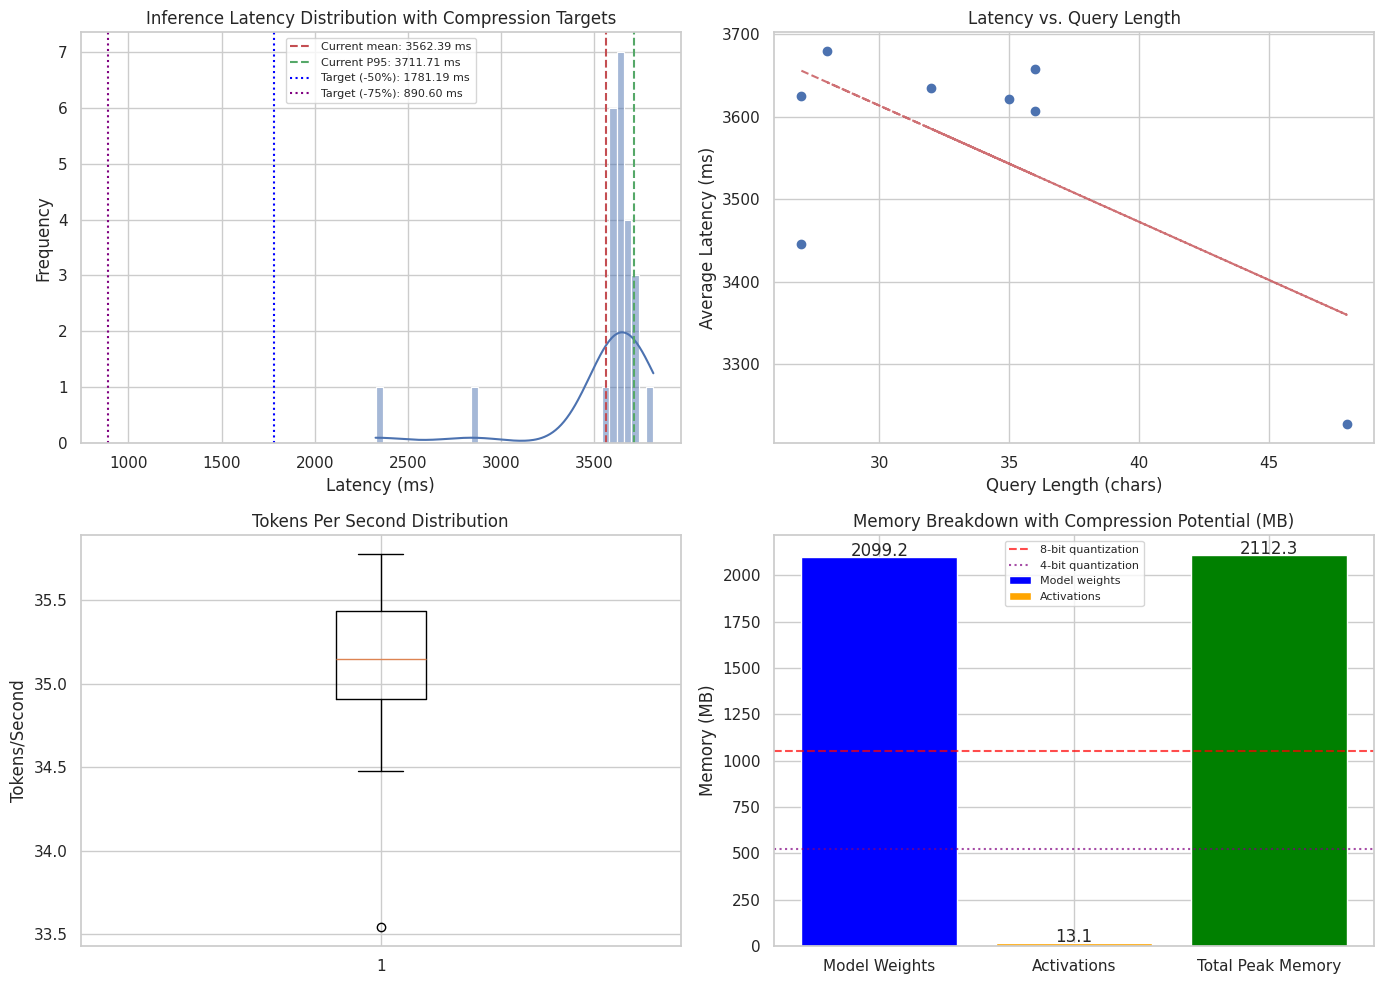

,Metric,Value (ms)
0,Cold Start,4547.189951
1,Average,3562.389900
2,P95,3711.710286
3,P99,3792.065995


In [9]:
# Create visualizations of benchmark results
def visualize_benchmark_results(results):
    """Create visualizations of benchmark results with focus on compression opportunities"""
    # Set up figure
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Latency distribution with compression targets
    sns.histplot(results["latency"], kde=True, ax=axs[0, 0])
    axs[0, 0].axvline(results["mean_latency"], color='r', linestyle='--', 
                   label=f'Current mean: {results["mean_latency"]:.2f} ms')
    axs[0, 0].axvline(results["p95_latency"], color='g', linestyle='--', 
                   label=f'Current P95: {results["p95_latency"]:.2f} ms')
    
    # Add target latency lines for compression goals
    axs[0, 0].axvline(results["mean_latency"]/2, color='blue', linestyle=':', 
                   label=f'Target (-50%): {results["mean_latency"]/2:.2f} ms')
    axs[0, 0].axvline(results["mean_latency"]/4, color='purple', linestyle=':', 
                   label=f'Target (-75%): {results["mean_latency"]/4:.2f} ms')
    
    axs[0, 0].set_title("Inference Latency Distribution with Compression Targets")
    axs[0, 0].set_xlabel("Latency (ms)")
    axs[0, 0].set_ylabel("Frequency")
    axs[0, 0].legend(fontsize=8)
    
    # 2. Latency by query length
    query_lengths = [len(q) for q in customer_queries]
    query_avg_latencies = [results[f"avg_latency_{i}"] for i in range(len(customer_queries))]
    
    axs[0, 1].scatter(query_lengths, query_avg_latencies)
    axs[0, 1].set_title("Latency vs. Query Length")
    axs[0, 1].set_xlabel("Query Length (chars)")
    axs[0, 1].set_ylabel("Average Latency (ms)")
    
    # Add trendline
    z = np.polyfit(query_lengths, query_avg_latencies, 1)
    p = np.poly1d(z)
    axs[0, 1].plot(query_lengths, p(query_lengths), "r--", alpha=0.8)
    
    # 3. Tokens per second across queries
    tokens_per_second = results["tokens_per_second"]
    axs[1, 0].boxplot(tokens_per_second)
    axs[1, 0].set_title("Tokens Per Second Distribution")
    axs[1, 0].set_ylabel("Tokens/Second")
    axs[1, 0].grid(True)
    
    # 4. Memory breakdown with compression targets
    # Calculate activations (peak memory - model size)
    activation_memory = results["peak_memory"] - metrics["technical"]["memory"]["model_size"]
    activation_memory = max(0, activation_memory)  # Ensure non-negative
    
    memory_data = [
        metrics["technical"]["memory"]["model_size"],  # Model weights
        activation_memory,  # Activations
        results["peak_memory"]  # Total peak
    ]
    
    memory_labels = [
        "Model Weights",
        "Activations",
        "Total Peak Memory"
    ]
    
    # Stack bar showing model size vs activations
    axs[1, 1].bar(memory_labels[0], memory_data[0], color='blue', label='Model weights')
    axs[1, 1].bar(memory_labels[1], memory_data[1], color='orange', label='Activations')
    axs[1, 1].bar(memory_labels[2], memory_data[2], color='green')
    
    # Add potential savings with different techniques
    weight_savings_8bit = memory_data[0] * 0.5  # 8-bit quantization saves ~50%
    weight_savings_4bit = memory_data[0] * 0.75  # 4-bit quantization saves ~75%
    activation_savings = activation_memory * 0.3  # Activation pruning saves ~30%
    
    # Overlay lines showing potential savings
    axs[1, 1].axhline(memory_data[0] - weight_savings_8bit, color='red', linestyle='--', 
                    label='8-bit quantization', alpha=0.7)
    axs[1, 1].axhline(memory_data[0] - weight_savings_4bit, color='purple', linestyle=':', 
                    label='4-bit quantization', alpha=0.7)
    
    axs[1, 1].set_title("Memory Breakdown with Compression Potential (MB)")
    
    axs[1, 1].set_ylabel("Memory (MB)")
    
    axs[1, 1].legend(fontsize=8)
    
    # Add values on top of bars
    
    for i, v in enumerate(memory_data):
        axs[1, 1].text(i, v + 5, f"{v:.1f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Display latency comparison table
    latency_data = {
        "Metric": ["Cold Start", "Average", "P95", "P99"],
        "Value (ms)": [
            results["cold_start_latency"][0],
            results["mean_latency"],
            results["p95_latency"],
            results["p99_latency"]
        ]
    }
    latency_df = pd.DataFrame(latency_data)
    display(latency_df)
    
# Run visualizations
print("Visualizing technical performance metrics...")
visualize_benchmark_results(benchmark_results)

> **Interpreting technical results**  
> When analyzing technical metrics, look for these key patterns:
> 
> - **Latency distribution shape**: A tight cluster indicates consistent performance, while a long tail suggests unpredictability. 
> - **P95/Mean ratio**: Values >1.5x indicate high variability that impacts user experience.
> - **Memory headroom**: Peak memory should leave at least 20% buffer to avoid OOM errors under load.
> - **Cold start penalty**: >2x average latency suggests costly scaling in dynamic environments.
> - **Unusual patterns**: The negative correlation between query length and latency seen here warrants further investigation with a larger sample.
> 
> These patterns directly point to specific optimization techniques—high memory usage suggests quantization, while high latency variance might indicate need for batching or pruning.

### B. Business benchmarking (simulation)

While technical metrics matter to engineers, business metrics translate performance into organizational impact. 

These metrics help stakeholders understand cost implications, scalability constraints, and infrastructure requirements, answering critical questions like _"How much will this cost at scale?"_ and _"Can we meet user demand with reasonable resources?"_.

Simulating business metrics...


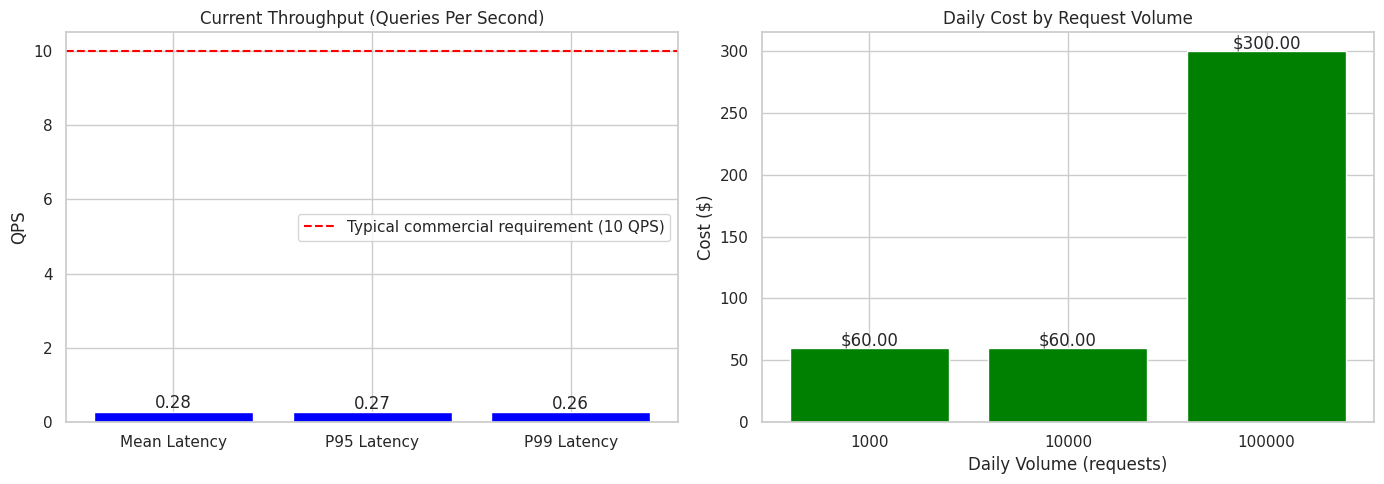


Current Business Metrics:


,Daily Volume,Instances Required,Daily Cost
0,1000,1.0,$60.00
1,10000,1.0,$60.00
2,100000,5.0,$300.00


Annual cost at 100K queries/day: $109500.00


In [10]:
def simulate_business_metrics(results):
    """Simulate business metrics based on benchmark results"""
    # Cost calculation assumptions
    hourly_cost = 2.50  # GPU instance cost
    
    # Calculate throughput metrics
    mean_latency_seconds = results["mean_latency"] / 1000
    qps_mean = 1 / mean_latency_seconds  # Queries per second based on mean latency
    qps_p95 = 1 / (results["p95_latency"] / 1000)  # QPS based on P95 latency
    qps_p99 = 1 / (results["p99_latency"] / 1000)  # QPS based on P99 latency
    
    # Calculate cost per request
    requests_per_hour = qps_mean * 3600
    cost_per_request = hourly_cost / requests_per_hour
    
    # Calculate costs at different scales
    daily_volume_scenarios = [1000, 10000, 100000]
    instance_requirements = []
    daily_costs = []
    
    for volume in daily_volume_scenarios:
        # Calculate required instances based on P95 latency (more conservative)
        hourly_volume = volume / 24  # Average hourly volume
        instances_needed = np.ceil(hourly_volume / (qps_p95 * 3600))
        daily_cost = instances_needed * hourly_cost * 24
        
        instance_requirements.append(instances_needed)
        daily_costs.append(daily_cost)
    
    # Create business metrics dataframe
    business_df = pd.DataFrame({
        "Daily Volume": daily_volume_scenarios,
        "Instances Required": instance_requirements,
        "Daily Cost": [f"${cost:.2f}" for cost in daily_costs]
    })
    
    # Create visualization of baseline metrics
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. QPS comparison
    qps_data = [qps_mean, qps_p95, qps_p99]
    qps_labels = ["Mean Latency", "P95 Latency", "P99 Latency"]
    
    axs[0].bar(qps_labels, qps_data, color='blue')
    axs[0].set_title("Current Throughput (Queries Per Second)")
    axs[0].set_ylabel("QPS")
    
    # Add reference line for "commercial" requirements
    axs[0].axhline(y=10, color='red', linestyle='--', label='Typical commercial requirement (10 QPS)')
    axs[0].legend()
    
    # Add values on top of bars
    for i, v in enumerate(qps_data):
        axs[0].text(i, v + 0.1, f"{v:.2f}", ha='center')
    
    # 2. Daily cost by volume
    axs[1].bar([str(v) for v in daily_volume_scenarios], daily_costs, color='green')
    axs[1].set_title("Daily Cost by Request Volume")
    axs[1].set_xlabel("Daily Volume (requests)")
    axs[1].set_ylabel("Cost ($)")
    
    # Add values on top of bars
    for i, v in enumerate(daily_costs):
        axs[1].text(i, v + 2, f"${v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Display business metrics
    print("\nCurrent Business Metrics:")
    display(business_df)
    
    # Calculate annual costs for high-volume scenario
    annual_cost = daily_costs[2] * 365
    print(f"Annual cost at 100K queries/day: ${annual_cost:.2f}")
    
    return {
        "cost_per_request": cost_per_request,
        "qps_mean": qps_mean,
        "qps_p95": qps_p95,
        "qps_p99": qps_p99,
        "daily_costs": daily_costs,
        "annual_high_volume_cost": annual_cost,
        "instance_requirements": instance_requirements
    }
# Run benchmarking
print("Simulating business metrics...")
business_metrics = simulate_business_metrics(benchmark_results)

>**Interpreting business results**  
> When analyzing business metrics, look for these key indicators:
> 
> - **QPS vs. user expectations**: Compare throughput with user requirements - most interactive applications need at least 5-10 QPS per instance to feel responsive.
> - **Cost scaling pattern**: Linear cost scaling with volume indicates efficient architecture, while exponential scaling suggests architectural bottlenecks.
> - **Annual TCO vs. business value**: Compare annual infrastructure costs against the business value generated - aim for at least 5-10x ROI.
> - **Response time vs. user patience**: For LLMs, research shows initial response should begin within 1-2s, full response within 5-7s, and >10-15s only for complex answers - compare your latency against these thresholds.
> - **Scaling breakpoint**: Identify the volume where cost efficiency significantly changes, indicating where architectural shifts become necessary.
> 
> These business patterns directly inform compression priorities—poor QPS-to-cost ratio suggests throughput optimization (pruning/distillation), while high annual costs relative to business value suggest more aggressive compression despite potential quality tradeoffs.

## Conclusion: Identifying compression opportunities

Based on our benchmark results, we can identify several potential optimization approaches. 

Let's summarize our findings and outline next steps for improving the model's performance:

In [11]:
# Create summary of findings
def create_summary(benchmark_results, business_metrics):
    """Create a summary of all findings with potential optimization directions"""
    print("\n" + "="*50)
    print("LANGUAGE MODEL BENCHMARK SUMMARY")
    print("="*50)
    
    print(f"\nModel: {model_name}")
    print(f"Size: {metrics['technical']['memory']['model_size']:.2f} MB")
    
    print("\nPERFORMANCE METRICS:")
    print(f"- Mean latency: {benchmark_results['mean_latency']:.2f} ms")
    print(f"- P95 latency: {benchmark_results['p95_latency']:.2f} ms")
    print(f"- Throughput: {business_metrics['qps_mean']:.2f} queries per second")
    print(f"- Memory usage: {benchmark_results['peak_memory']:.2f} MB peak")
    
    print("\nBUSINESS IMPACT:")
    print(f"- Cost per request: ${business_metrics['cost_per_request']:.6f}")
    print(f"- Daily cost (10K requests): ${business_metrics['daily_costs'][1]:.2f}")
    
    print("\nOPTIMIZATION OPPORTUNITIES:")
    
    # Analyze latency pattern
    latency_variance = np.std(benchmark_results["latency"])
    p95_to_mean_ratio = benchmark_results["p95_latency"] / benchmark_results["mean_latency"]
    
    if p95_to_mean_ratio > 1.5:
        print("- High latency variance detected. Potential optimizations:")
        print("  → Investigate batch processing for more consistent performance")
        print("  → Consider quantization to improve worst-case latency")
    
    # Analyze memory usage
    memory_headroom = 100 - (benchmark_results["peak_memory"] / 16000 * 100)  # Assuming 16GB limit
    
    if memory_headroom < 50:
        print("- Limited memory headroom detected. Potential optimizations:")
        print("  → 8-bit quantization could reduce memory footprint by ~75%")
        print("  → Model pruning might reduce size by 30-60% with minimal accuracy impact")
    
    # Based on model size
    if metrics["technical"]["memory"]["model_size"] > 1000:
        print("- Large model detected. Potential optimizations:")
        print("  → Knowledge distillation to a smaller model architecture")
        print("  → Layer-wise weight sharing or factorization")
    
    # Based on throughput
    if business_metrics["qps_mean"] < 5:
        print("- Throughput bottlenecks detected. Potential optimizations:")
        print("  → Explore token-level early stopping for faster generation")
        print("  → Implement attention mechanism optimizations")
        print("  → Consider smaller model architectures for critical paths")
    
    print("\nRECOMMENDED NEXT STEPS:")
    print("1. Select the most promising compression techniques based on your requirements")
    print("2. Benchmark each technique individually to measure specific impacts")
    print("3. Perform A/B testing to validate actual impact on response quality")
    print("4. Monitor user satisfaction metrics after deployment")
    
    print("="*50)

# Run summary
create_summary(benchmark_results, business_metrics)


LANGUAGE MODEL BENCHMARK SUMMARY

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Size: 2099.18 MB

PERFORMANCE METRICS:
- Mean latency: 3562.39 ms
- P95 latency: 3711.71 ms
- Throughput: 0.28 queries per second
- Memory usage: 2112.33 MB peak

BUSINESS IMPACT:
- Cost per request: $0.002474
- Daily cost (10K requests): $60.00

OPTIMIZATION OPPORTUNITIES:
- Large model detected. Potential optimizations:
  → Knowledge distillation to a smaller model architecture
  → Layer-wise weight sharing or factorization
- Throughput bottlenecks detected. Potential optimizations:
  → Explore token-level early stopping for faster generation
  → Implement attention mechanism optimizations
  → Consider smaller model architectures for critical paths

RECOMMENDED NEXT STEPS:
1. Select the most promising compression techniques based on your requirements
2. Benchmark each technique individually to measure specific impacts
3. Perform A/B testing to validate actual impact on response quality
4. Monitor user satisf

> **Communicating results**: When presenting benchmark results:
> 1. Start with the business impact (costs, user experience)
> 2. Support with technical metrics that demonstrate why the recommendations make sense
> 3. Provide clear, actionable next steps
> 4. Quantify expected benefits in terms stakeholders value ($$, user satisfaction)